# Reaching multiple targets with a manipulator
The objective of this exercice is to introduce the implementation of the front-end based on Pinocchio, for polyarticulated systems modeled in position-velocity-torque.

We provide a basic example for reaching one point with a manipulator robot. You are then guided to modify this example for sequence of multiple targets. 

## Set up

In [1]:
import gepetuto.magic

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide
    the solutions to some questions. Change it for %load if you want to see (and
    execute) the solution.


This notebook is also based on Crocoddyl. Our optimal control toolbox is composed of 3 main parts: **the backend** contains the API for solving the problem and accessing the solution and implements several solvers, DDP being the first one; **the frontend** is first composed of a basic API which we mostly used in the exercice with unicycle and bicopter, and that you can use to implement any fancy problem; finally, **a particular implementation of the front end using Pinocchio** is mostly written for working with polyarticulated systems such as manipulator robots.

We will need crocoddyl as in the previous notebook, with the model of the arm of the humanoid robot Talos, a 7-dof arm. It can be found in example robot data.

In [2]:
# %load tp3/generated/panda_reaches_a_single_target_import
import crocoddyl
import pinocchio as pin
import numpy as np
import example_robot_data as robex
import matplotlib.pylab as plt
import time


In this notebook, we will give an introduction to the multibody (Pinocchio) front-end of Crocoddyl. In the first part, we will use the classical DDP solver (back-end). In the second part, we will use the more recent MIM Solver, which can handle hard constraint. It is available in the PyPI package [cmeel-mim-solvers](https://pypi.org/project/cmeel-mim-solvers/).

In [3]:
import mim_solvers

## Panda reaches a single target

### Panda robot model

First, let's load the Pinocchio model for the Panda arm.

In [4]:
# %load tp3/generated/panda_reaches_a_single_target_robexload
# First, let's load the Pinocchio model for the Panda arm.
robot = robex.load('panda')
# The 2 last joints are for the fingers, not important in arm motion, freeze them
robot.model,[robot.visual_model,robot.collision_model] = \
    pin.buildReducedModel(robot.model,[robot.visual_model,robot.collision_model],[8,9],robot.q0)
robot.q0 = robot.q0[:7].copy()


The optimal control problem is defined by a bunch of hyperparameters.

In [5]:
# %load tp3/generated/panda_reaches_a_single_target_hyperparameters
HORIZON_LENGTH = 100
TIME_STEP = 1e-2
FRAME_TIP = robot.model.getFrameId("panda_hand_tcp")
GOAL_POSITION = np.array([.2,0.6,.5])
GOAL_PLACEMENT = pin.SE3(pin.utils.rpyToMatrix(-np.pi,-1.5,1.5), GOAL_POSITION)
REACH_DIMENSION = "3d" # "6d"


Set robot model.

In [13]:
# %load tp3/generated/panda_reaches_a_single_target_robot_model
# Set robot model
robot_model = robot.model
robot_model.armature = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])*.1
robot_model.q0 = np.array([3.5,2,2,0,0,0,0])
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])
robot_model.gravity *= 0


We will use meshcat for displaying the model.

In [14]:
# %load tp3/generated/panda_reaches_a_single_target_viz
from wan2024.meshcat_viewer_wrapper import MeshcatVisualizer
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
viz.addBox('world/goal',[.1,.1,.1],[0,1,0,1])
viz.applyConfiguration('world/goal',GOAL_PLACEMENT)


*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [15]:
viz.viewer.jupyter_cell()

The model is augmented with a default state $x_0$, and armature is added to the joints to model the gear reduction.

In [16]:
# %load tp3/generated/panda_reaches_a_single_target_robot_model
# Set robot model
robot_model = robot.model
robot_model.armature = np.ones(robot.model.nv)*2 # Arbitrary value representing the true armature
robot_model.q0 = robot.q0.copy()
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])


### Cost and dynamics
This starts with specifying the state space, defined by $x=(q,v)$. 

In [17]:
# %load tp3/generated/panda_reaches_a_single_target_state
state = crocoddyl.StateMultibody(robot_model)


The cost is defined as a sum of multiple terms. The classes CostSum are created to store the terms. Let's have one for the running nodes, and one for the terminal node.

We need to first define a cost model (i.e. set of cost functions) in order to next define the action model for our optimal control problem.
For this particular example, we formulate three running-cost functions: goal-tracking cost, state and control regularization; and a terminal cost: goal cost. First, let's create the common cost functions.

In [18]:
# %load tp3/generated/panda_reaches_a_single_target_sumofcosts
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)


We define a cost for reaching the target, either as a 3D objective $\ell(x) = \| p(q)-p^*\|^2$, or as a 6D objective $\ell(x) = \| \log( \ ^0M_E(q)^{-1} \ ^0M_* ) \|^2$, with $p^* \in \mathbb{R^3}$ the goal position, and $^0M_* \in SE(3)$ the goal placement.

In [19]:
# %load tp3/generated/panda_reaches_a_single_target_cost_goal
if REACH_DIMENSION == "3d":
    # Cost for 3d tracking || p(q) - pref ||**2
    goalTrackingRes = crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,GOAL_POSITION)
    goalTrackingWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1]))
elif REACH_DIMENSION == "6d":
    # Cost for 6d tracking  || log( M(q)^-1 Mref ) ||**2
    goalTrackingRes = crocoddyl.ResidualModelFramePlacement(state,FRAME_TIP,GOAL_PLACEMENT)
    goalTrackingWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1, 1,1,1]))
else:
    assert( REACH_DIMENSION=="3d" or REACH_DIMENSION=="6d" )
goalTrackingCost = crocoddyl.CostModelResidual(state,goalTrackingWeights,goalTrackingRes)
runningCostModel.addCost("gripperPose", goalTrackingCost, .001)
terminalCostModel.addCost("gripperPose", goalTrackingCost, 4)


Next we add regularization. First a state regularization.

In [20]:
# %load tp3/generated/panda_reaches_a_single_target_cost_xreg
# Cost for state regularization || x - x* ||**2
# We set up different values for the integral cost and terminal cost term.

# Regularization is stronger on position than velocity (to account for typical unit scale)
xRegWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, .1,.1,.1,.1,.1,.1,.1]))
xRegRes = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCost = crocoddyl.CostModelResidual(state,xRegWeights,xRegRes)
runningCostModel.addCost("xReg", xRegCost, 1e-3)

# Terminal cost for state regularization || x - x* ||**2
# Require more strictly a small velocity at task end (but we don't car for the position)
xRegWeightsT=crocoddyl.ActivationModelWeightedQuad(np.array([.5,.5,.5,.5,.5,.5,.5,  5.,5.,5.,5.,5.,5.,5.]))
xRegResT = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCostT = crocoddyl.CostModelResidual(state,xRegWeightsT,xRegResT)
terminalCostModel.addCost("xReg", xRegCostT, .01)


Then a control regularization.

In [21]:
# %load tp3/generated/panda_reaches_a_single_target_cost_ureg
# Cost for control regularization || u - g(q) ||**2
uRegRes = crocoddyl.ResidualModelControlGrav(state)
uRegCost = crocoddyl.CostModelResidual(state,uRegRes)
runningCostModel.addCost("uReg", uRegCost, 1e-6)


### Action model 
Next, we need to create an action model for running and terminal nodes. We follow the same logic already explained with the bicopter: a differential action model (DAM) for the forward dynamics and the cost integrals, then a numerical integration in the integrator action model (IAM).

In [22]:
# %load tp3/generated/panda_reaches_a_single_target_iam
# Next, we need to create the running and terminal action model.
# The forward dynamics (computed using ABA) are implemented
# inside DifferentialActionModelFullyActuated.

# The actuation model is here trivial: tau_q = u.
actuationModel = crocoddyl.ActuationModelFull(state)
# Running model composing the costs, the differential equations of motion and the integrator.
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel), TIME_STEP)
runningModel.differential.armature = robot_model.armature
# Terminal model following the same logic, although the integration is here trivial.
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
terminalModel.differential.armature = robot_model.armature


### Optimal control problem 
Once we have the action models, we just have to shape them into an optimal control problem.


In [23]:
# %load tp3/generated/panda_reaches_a_single_target_shoot
problem = crocoddyl.ShootingProblem(robot_model.x0, [runningModel] * HORIZON_LENGTH, terminalModel)


### Solve and display
We finalize the set up by creating the DDP solver for this optimal control problem.

In [24]:
# %load tp3/generated/panda_reaches_a_single_target_solve
# Solving it using DDP
# Create the DDP solver for this OC problem, verbose traces, with a logger
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([
    crocoddyl.CallbackLogger(),
    crocoddyl.CallbackVerbose(),
])

# Solving it with the DDP algorithm
ddp.solve([],[],1000)  # xs_init,us_init,maxiter


iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  2.589e+00  0.000e+00  8.822e-01  1.764e+00  1.000e-09  1.000e-09  1.0000  2.356e+00  0.000e+00  0.000e+00  8.822e-01 -1.608e+00  0.000e+00  0.000e+00
   1  1.858e+00  0.000e+00  2.521e+00  5.043e+00  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  1.891e+00  7.306e-01  0.000e+00  0.000e+00
   2  1.186e+00  0.000e+00  1.789e+00  3.578e+00  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.789e+00  6.722e-01  0.000e+00  0.000e+00
   3  9.212e-01  0.000e+00  1.103e+00  2.206e+00  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  8.274e-01  2.650e-01  0.000e+00  0.000e+00
   4  7.467e-01  0.000e+00  8.322e-01  1.664e+00  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  6.242e-01  1.745e-01  0.000e+00  0.000e+00
   5  5.722e-01  0.000e+00  7.424e-01  1.485e+00  1.000e-09  1.000e

True

You can now look at the results, either by plotting it or animating the trajectory in the viewer.

In [25]:
%matplotlib inline

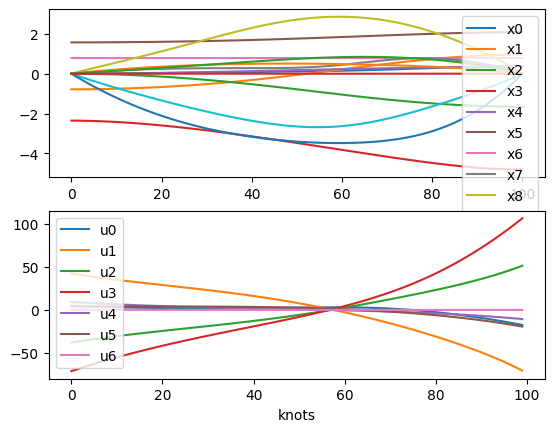

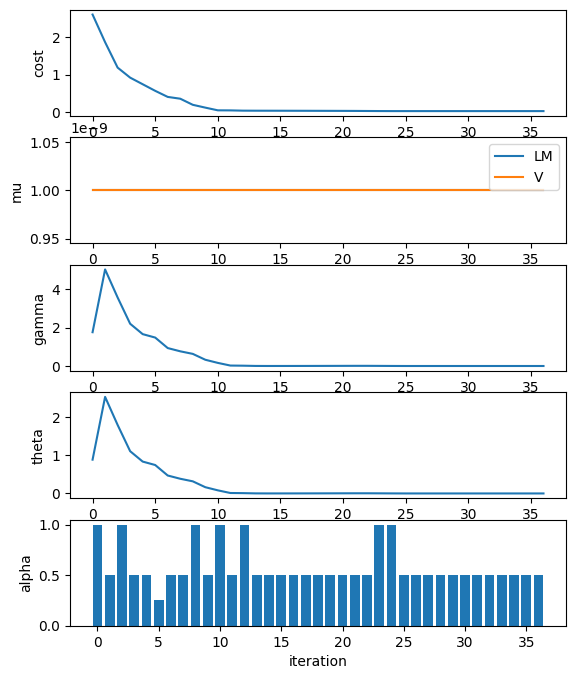

In [26]:
# %load tp3/generated/panda_reaches_a_single_target_plot
# Plotting the solution and the DDP convergence
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)


In [ ]:
viz.viewer.jupyter_cell()

In [ ]:
# %load tp3/generated/panda_reaches_a_single_target_animate
# # Visualizing the solution in gepetto-viewer
viz.play([x[:robot.model.nq] for x in ddp.xs],TIME_STEP)

## Extending the example for reaching a sequence of targets

Now we ask you to modify this example to reach a sequence of targets $p_{*1},p_{*2},p_{*3},p_{*4}$. The optimal trajectory should use similar regularization, but with the reaching cost now varying it time: for the first quarter of nodes, the target is $p_{*1}$, then another quarter with $p_{*2}$ etc until the four targets are reached. Don't specify a particular velocity when reaching the point to let more freedom to the solver.

Below is a quick guideline to help you.

### First step: prepare the environment

Start by defining several targets (let's say 4 targets, all at x=0.4, and at y and z being either 0 or 0.4), and display then in the viewer.

### Second step: define the shooting problem

The shooting problem will be composed of 4 sequences of action models. Each sequence consists on T shooting "running" nodes and 1 terminal node. The running nodes mostly have regularization terms, while the terminal nodes have a strong cost toward the respective target.

$[ R_1,R_1,R_1 ... R_1,T_1, R_2,R_2 .... R_2, T_2, R_3 ... R_3, T_3, R_4 ... R_4 ] , T4

First create 4 running models and 4 terminal models.

Then you need to add a position cost, and state and control regularization to each running action model. Please  note that for terminal action model is only needed the position cost. Additionally, in the running models, the position cost should be low, and it should be high in the terminal models.

Now create a shooting problem.

In [ ]:
seq0 = [runningModels[0]]*T + [terminalModels[0]]
seq1 = [runningModels[1]]*T + [terminalModels[1]]
seq2 = [runningModels[2]]*T + [terminalModels[2]]
seq3 = [runningModels[3]]*T 
problem = crocoddyl.ShootingProblem(x0,seq0+seq1+seq2+seq3,terminalmodel[3])

Create a DDP solver for this problem and run it. 

In [ ]:
ddp = crocoddyl.SolverDDP(problem)
ddp.solve()

Well, it should not work, at least no on the first shot. The DDP solver is likely not strong enough to accept the random weights that you have selected. 

If it is working nicely from the first shot, display it in the viewer and go take a coffee. But you will likely have to tweak the gains to make it work.

**It is suggested to first optimize only sequence 1. When you are happy with it, add sequence 2 and optimize again, etc.**


### Toward hard constraints

The solver works with double precisions, so it is quite robust to high weight. 10000 is likely to be accepted for example. But if you make the problem too difficult, the solver will break. 
In that case, you can implement a simple penalty solver by setting the weight to be 10**i, and creating a for loop to explore i from 0 to 5. At each iteration of the loop, run the solver from the previous solution and for few iterations only.

In [ ]:
for i in range(1,6):
    for m in terminalModels:
        m.costs.costs['gripperPose'].weight = 10**i
    ddp.solve(ddp.xs, ddp.us, 10)

This not very convenient, and a better solver should be used if you really want imposing hard constraints. Let's do that next.

----
## Adding hard constraints

### MIM Solver

In this last chapter, we guide you through the advanced, more recent, constraint interface. It is composed of two parts. First, constraints can be defined in the front end, following a similar logic to costs, and using again the residual models. That should be pretty straight forward now you are proficient with cost models. Second, we need another solver. DDP is not aware of constraints and would just skip them. More advanced solvers are available. We propose here to use the recent SQP from the team "Machine in Motion" led by Ludovic Righetti at NYU, described in 
https://laas.hal.science/hal-04330251

The implementation of the solver is available is the GitHub repository https://github.com/machines-in-motion/mim_solvers

### Preparing the environment
For this example, we will impose a virtual wall in front of the robot, with the following parameters.

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_hyperparameters
X_WALL_LOWER = .25
X_WALL_UPPER = .35


### Defining the constraints

Similarly to the sum-of-costs, all constraints must be stored in a constraint manager, which is given as initial argument when building a differential action model.

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_constraint_manager
# Define contraint
runningConstraints = crocoddyl.ConstraintModelManager(state, robot.nv)


We propose here to introduce a virtual wall constraining the end effector. For that, we use the same frame-translation residual. The constraint is defined along each axis with constant bounds, and np.inf when a particular direction should not be considered.

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_eewall
# Create contraint on end-effector
frameTranslationResidual = crocoddyl.ResidualModelFrameTranslation(
    state, FRAME_TIP, np.zeros(3)
)
eeWallContraint = crocoddyl.ConstraintModelResidual(
    state,
    frameTranslationResidual,
    np.array([X_WALL_LOWER, -np.inf, -np.inf]),
    np.array([X_WALL_UPPER, +np.inf, +np.inf]),
)
runningConstraints.addConstraint("ee_wall", eeWallContraint)


Then you can build a new action model with this constraint. We advise you don't constrain the initial node, as it easily leads to a unfeasible problem if $x_0$ does not satisfy the constraints. 

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_iam
# Next, we need to create the running and terminal action model.
# The forward dynamics (computed using ABA) are implemented
# inside DifferentialActionModelFullyActuated.

# The actuation model is here trivial: tau_q = u.
actuationModel = crocoddyl.ActuationModelFull(state)
# Running model composing the costs, the differential equations of motion and the integrator.
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel, runningConstraints),
    TIME_STEP)
runningModel.differential.armature = robot_model.armature
# Specific unconstrained initial model
runningModel_init = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel),
    TIME_STEP)
runningModel.differential.armature = robot_model.armature
# Terminal model following the same logic, although the integration is here trivial.
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
terminalModel.differential.armature = robot_model.armature


In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_shoot
problem = crocoddyl.ShootingProblem(robot_model.x0,
                                    [runningModel_init] + [runningModel] * (HORIZON_LENGTH - 1),
                                    terminalModel)


### Working with the SQP solver of MIM
The solver follows a very similar syntax to the DDP solver. 

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_solver
solver = mim_solvers.SolverCSQP(problem)
solver.with_callbacks = True 
solver.termination_tolerance = 1e-3         # Termination criteria (KKT residual)
solver.max_qp_iters = 1000                  # Maximum number of QP iteration
solver.eps_abs = 1e-5                       # QP termination absolute criteria, 1e-9 
solver.eps_rel = 0.                         # QP termination absolute criteria
solver.use_filter_line_search = True        # True by default, False = use merit function


Now solver, and as usual plot the result and animate the motion.

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_solve_and_plot
# Solving it with the DDP algorithm
solver.solve([],[],1000)  # xs_init,us_init,maxiter
#assert( ddp.stop == 1.9384159634520916e-10 )

ees = [ d.differential.pinocchio.oMf[FRAME_TIP].translation for d in solver.problem.runningDatas ]
plt.plot(ees)
plt.plot([0,HORIZON_LENGTH],[X_WALL_UPPER,X_WALL_UPPER],'b--')
plt.plot([0,HORIZON_LENGTH],[X_WALL_LOWER,X_WALL_LOWER],'b--')
plt.legend(['x', 'y', 'z'])


In [ ]:
viz.viewer.jupyter_cell()

In [ ]:
# %load tp3/generated/panda_reaches_with_constraints_animate
# Visualizing the solution in gepetto-viewer
viz.play([x[:robot.model.nq] for x in solver.xs],TIME_STEP)


----
## Exercice
Using all the content provided in this notebook, you can now write your own optimal control problem solving a 4-point sequences with virtual walls.

Based on the 4-point OCP you wrote in the first part: the motion finally obtained is typically a circle containing the four target points. You can then try to add two sets of constraints:

1. Add some bounds to sharpen the circle, so that the arcs are flattened by the virtual walls.
2. Add joint limits. You will use the residual state for that. The bounds can be obtained from the URDF model through:

In [ ]:
robot_model.lowerPositionLimit, robot_model.upperPositionLimit, robot_model.velocityLimit